In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import time
from sklearn.metrics import accuracy_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    W1 = np.random.normal(loc=0, scale=1, size=(input_size, hidden_size))
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.normal(loc=0, scale=1, size=(hidden_size, output_size))
    b2 = np.zeros((1, output_size))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

def forward_propagation(X, parameters):
    Z1 = np.dot(X, parameters['W1']) + parameters['b1']
    A1 = relu(Z1)
    Z2 = np.dot(A1, parameters['W2']) + parameters['b2']
    A2 = sigmoid(Z2)
    return {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

def predict(X, parameters):
    forward = forward_propagation(X, parameters)
    return (forward['A2'] > 0.5).astype(int)

# Set up neural network parameters
input_size = 100
hidden_size = 264
output_size = 1
n_samples = 1000

# Generate random input data
np.random.seed(42)

# Generate the first 33 variables using the neural network
X_first_33 = np.random.normal(loc=0, scale=1, size=(500, 33))
parameters = initialize_parameters(33, hidden_size, output_size)
forward = forward_propagation(X_first_33, parameters)
y_neural_network = forward['A2']

# Generate random values for the remaining variables
X_rest = np.random.normal(loc=0, scale=1,size=(500, input_size - 33))

# Combine the generated values
X = np.concatenate((X_first_33, X_rest), axis=1)

# Threshold for binary classification
threshold =0.5
y_binary_neural_network = (y_neural_network > threshold).astype(int)

# Add the generated y values to the existing DataFrame
data = pd.DataFrame(X, columns=[f'var{i}' for i in range(input_size)])
data['y'] = y_binary_neural_network


In [35]:
import numpy as np
from scipy.sparse.linalg import eigsh

## some useful functions
def get_arccos(X):
    # X is a 2-d array
    n, p = X.shape
    cos_a = np.zeros([n, n, n])
    
    for r in range(n):
        
        xr = X[r]
        X_r = X - xr
        cross = np.dot(X_r, X_r.T)
        row_norm = np.sqrt(np.sum(X_r**2, axis = 1))
        outer_norm = np.outer(row_norm, row_norm)
        
        zero_idx = (outer_norm == 0.)
        outer_norm[zero_idx] = 1.
        cos_a_kl = cross / outer_norm
        cos_a_kl[zero_idx] = 0.

        cos_a[:,:,r] = cos_a_kl
        
    cos_a[cos_a > 1] = 1.
    cos_a[cos_a < -1] = -1.
    a = np.arccos(cos_a)

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
        
    return a, A

def get_arccos_1d(X):
    # X is a 1-d array
    
    X = np.squeeze(X)
    Y = X[:,None] - X
    Z = Y.T[:,:,None]*Y.T[:,None]
    n = len(X)
    
    a = np.zeros([n, n, n])
    a[Z == 0.] = np.pi/2.
    a[Z < 0.] = np.pi
    
    a = np.transpose(a, (1,2,0))
    
    #a = Z[Z>0.]*0. + Z[Z==0.]*np.pi/2. + Z[Z<0.]*np.pi

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
    
    return a, A

def orthonormalize(X):
    # X is a 2-d array
    # output: Gram-Schmidt orthogonalization of X
    
    n, p = X.shape
    Y = np.zeros([n,p])
    Y[:,0] = X[:,0]/np.sqrt(np.sum(X[:,0]**2))
    
    for j in range(1,p):
        
        Yj = Y[:,range(j)]
        xj = X[:,j]
        w = np.dot(xj, Yj)
        xj_p = np.sum(w*Yj, axis = 1)
        yj = xj - xj_p
        yj = yj/np.sqrt(np.sum(yj**2))
        
        Y[:,j] = yj
        
    return Y

# Main functions
def projection_corr(X, Y):
    # X, Y are 2-d array
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1d(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos_1d(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1dy(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def get_equi_features(X):
    # X is 2-d array
    
    n, p = X.shape
    scale = np.sqrt(np.sum(X**2, axis=0))
    Xstd = X / scale
    sigma = np.dot(Xstd.T, Xstd)
    sigma_inv = np.linalg.inv(sigma)
    lambd_min = eigsh(sigma, k=1, which='SA')[0].squeeze()
    sj = np.min([1., 2.*lambd_min])
    sj = sj - 0.00001
    
    mat_s = np.diag([sj]*p)
    A = 2*mat_s - sj*sj*sigma_inv
    C = np.linalg.cholesky(A).T
    
    Xn = np.random.randn(n, p)
    XX = np.hstack([Xstd, Xn])
    XXo = orthonormalize(XX)
    U = XXo[:,range(p,2*p)]
    
    Xnew = np.dot(Xstd,  np.eye(p) - sigma_inv*sj) + np.dot(U,C)
    return Xnew

In [36]:
X = data.iloc[:,:-1]
X = (X - X.mean()) / X.std()
Y = data.iloc[:,-1]
X_knockoff = get_equi_features(X)
X_knockoff = (X_knockoff - X_knockoff.mean()) / X_knockoff.std()

In [37]:
X_knockoff_df = pd.DataFrame(X_knockoff)
column_names = ['feature0_k', 'feature1_k', 'feature2_k', 'feature3_k', 'feature4_k','feature5_k', 'feature6_k', 'feature7_k', 'feature8_k', 'feature9_k',
                'feature10_k', 'feature11_k', 'feature12_k', 'feature13_k', 'feature14_k','feature15_k', 'feature16_k', 'feature17_k', 'feature18_k', 'feature19_k',
                'feature20_k', 'feature21_k', 'feature22_k', 'feature23_k', 'feature24_k','feature25_k', 'feature26_k', 'feature27_k', 'feature28_k', 'feature29_k',
                'feature30_k', 'feature31_k', 'feature32_k', 'feature33_k', 'feature34_k','feature35_k', 'feature36_k', 'feature37_k', 'feature38_k', 'feature39_k',
                'feature40_k', 'feature41_k', 'feature42_k', 'feature43_k', 'feature44_k','feature45_k', 'feature46_k', 'feature47_k', 'feature48_k', 'feature49_k',
                'feature50_k', 'feature51_k', 'feature52_k', 'feature53_k', 'feature54_k','feature55_k', 'feature56_k', 'feature57_k', 'feature58_k', 'feature59_k',
                'feature60_k', 'feature61_k', 'feature62_k', 'feature63_k', 'feature64_k','feature65_k', 'feature66_k', 'feature67_k', 'feature68_k', 'feature69_k',
                'feature70_k', 'feature71_k', 'feature72_k', 'feature73_k', 'feature74_k','feature75_k', 'feature76_k', 'feature77_k', 'feature78_k', 'feature79_k',
                'feature80_k', 'feature81_k', 'feature82_k', 'feature83_k', 'feature84_k','feature85_k', 'feature86_k', 'feature87_k', 'feature88_k', 'feature89_k',
                'feature90_k', 'feature91_k', 'feature92_k', 'feature93_k', 'feature94_k','feature95_k', 'feature96_k', 'feature97_k', 'feature98_k', 'feature99_k']
X_knockoff_df.columns = column_names
feature = pd.concat([X,X_knockoff_df],axis = 1)
dataset1 =  pd.concat([feature,data['y']],axis = 1)
dataset1

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,feature91_k,feature92_k,feature93_k,feature94_k,feature95_k,feature96_k,feature97_k,feature98_k,feature99_k,y
0,0.461406,-0.138062,0.678772,1.527778,-0.218823,-0.145966,1.500183,0.711481,-0.433734,0.501047,...,-0.979433,0.463950,-0.384183,0.512113,0.015657,-0.690012,-0.558037,-0.565508,2.721553,1
1,-1.059556,0.807638,-1.180781,0.244734,-2.025435,-1.232025,0.165041,0.682626,0.208686,-0.157825,...,-1.279174,0.652524,-0.121155,-0.345293,1.321991,0.690405,0.350790,0.369794,0.931040,0
2,-0.095075,0.985780,0.394094,-0.589024,0.404716,1.613266,-0.059700,1.505561,-2.589300,0.780671,...,0.694236,0.497791,0.024633,0.594199,-0.417800,-1.647849,0.540547,0.611145,-0.013600,1
3,-0.254152,-1.395087,-0.384428,-0.293781,-0.813647,-0.073646,0.365155,1.825841,0.211904,0.215750,...,-2.084411,1.355300,-0.607549,-0.210499,1.020312,-0.815541,-1.246425,-1.357394,0.573031,0
4,-1.064050,0.464173,-0.880810,1.554045,-0.793729,-0.233248,0.760637,-1.278976,0.264916,1.266400,...,1.040937,-1.547896,1.017070,-0.096840,2.970988,-1.034747,0.388984,1.671235,-0.286414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-2.719838,0.245937,-0.380494,-0.174807,-0.923690,-0.060646,1.319356,-0.497589,1.004847,-0.849204,...,-1.261415,1.671708,1.207839,3.024718,3.153122,0.406847,-0.757302,-1.000496,0.115265,0
496,-1.249367,0.019293,0.859484,0.192001,0.329237,1.219954,-0.738992,-0.272049,1.675527,-0.239070,...,1.068995,-1.610087,1.177215,-1.067030,-0.069279,-0.856657,0.215517,-0.481231,1.749924,0
497,0.559587,0.877735,1.646569,1.005932,0.093156,-1.212238,0.125245,0.202628,0.747672,1.313196,...,0.004768,0.109657,-0.461855,1.119496,0.730847,-1.192008,1.568252,-0.299782,-0.661093,1
498,-1.515261,0.175513,0.699545,-1.373012,-0.187130,0.797151,-2.858676,1.277270,0.391446,0.675390,...,0.115898,0.706394,0.489416,-1.144433,1.015803,0.695032,0.517188,-1.165706,2.305960,0


In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

lambda_array = np.zeros((200, 264))
lambda_array2 = np.zeros((264, 1))
input_dim = 200

# Use tqdm for a one-line progress bar
for i in tqdm(np.arange(0, 7, 0.05)):
    model = keras.Sequential()
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    #model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)

    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    
    for j in range(min(len(weights), len(lambda_array))):
        for n in range(min(len(weights[j]), len(lambda_array[j]))):
            if abs(weights[j][n]) < 5e-4 and lambda_array[j][n] == 0:
                lambda_array[j][n] = i
    
    # Calculate the Zi in second layer
    second_layer = model.layers[1]
    weights, biases = second_layer.get_weights()
    #print(f"Layer: {layer.name}, Weights: {weights}")
#     print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 5e-4 and lambda_array2[j][n] == 0 :
#                 print(j,n)
                lambda_array2[j][n] = i
print(lambda_array)


100%|██████████| 140/140 [07:59<00:00,  3.42s/it]

[[0.05 1.15 0.1  ... 0.6  0.55 0.75]
 [0.05 0.05 0.15 ... 0.6  0.55 0.75]
 [0.05 0.05 0.1  ... 0.05 0.05 0.2 ]
 ...
 [0.05 0.35 0.15 ... 0.25 0.2  0.25]
 [0.05 0.4  0.15 ... 0.1  0.2  0.2 ]
 [0.05 0.3  0.15 ... 0.3  0.2  0.4 ]]


In [39]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"max_weight: {min_weights}")
print(f"min_weight: {max_weights}")

max_weight: 0.0011212409008294344
min_weight: 0.2797025144100189


In [40]:
non_zero_lambda_array = lambda_array[np.nonzero(lambda_array)]
min_non_zero_lambda = np.min(np.abs(non_zero_lambda_array))
max_lambda = np.max(abs(lambda_array))
#for i in lambda_array:
    #print(i)
print(f"min_lambda (except 0): {min_non_zero_lambda}")
print(f"max_lambda: {max_lambda}")
count_min_non_zero_lambda = np.count_nonzero(np.abs(lambda_array) == 0)
print(f"number of 0: {count_min_non_zero_lambda}")

min_lambda (except 0): 0.05
max_lambda: 1.25
number of 0: 0


In [41]:
def compute_W1(lambda_array):
    lambda_array = np.where(lambda_array == 0, 8, lambda_array)
    row_sums1 = np.sum(lambda_array, axis=1)
    W1 = []
    for i in range(0,int(0.5*len(row_sums1)),1):
        if row_sums1[i]>=row_sums1[i+100]:
            W1.append(row_sums1[i])
        else:
            W1.append(-row_sums1[i+100])
    return W1,row_sums1

def select_variables1(W,target_q):
    T = []
    for i in W1:
        count1 = 0
        count2 = 0
        t = abs(i)
        for j in W1:
            if j < -t:
                count1 = count1+1
            if j >= t:
                count2 = count2 +1
        q = (count1)/(max(count2,1))
    #     print(count1,count2,q)
        if q <= target_q:
            T.append(t)
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:

W1, row_sums1 = compute_W1(lambda_array)
selected_vars1, threshold_value1 = select_variables1(W1,0.01)
selected_vars1, threshold_value1

([2, 7, 8, 11, 14, 17, 20, 21, 23, 24, 25, 26, 27, 28, 31, 32], 68.85)

In [42]:
def compute_W2(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
#     print(w_m)
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
#         print(w_m)
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
#     print(row_sums)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2/10000 - Z[i+100]**2/10000 for i in range(int(len(Z)/2))]
#     print(Z[i]**2)
#     print(row_sums)
    return W,Z

def select_variables2(W,target_q):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < target_q:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:

model_2 = keras.Sequential()
model_2.add(layers.Dense(264, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
W2,Z = compute_W2(model_2, lambda_array)
selected_vars2, threshold_value2 = select_variables2(W2,0.01)
selected_vars2, threshold_value2

([2, 7, 8, 11, 14, 17, 21, 24, 25, 27, 28, 31, 32],
 array([0.7026994], dtype=float32))

/tmp/ipykernel_47/1364793661.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Tar_FDR, T_FDR, c='purple', cmap='viridis', marker='o',s=20)
/tmp/ipykernel_47/1364793661.py:59: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Tar_FDR, power, c='green', cmap='viridis', marker='o',s=20)
/tmp/ipykernel_47/1364793661.py:71: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Tar_FDR, p_f, c='blue', cmap='viridis', marker='o',s =20)


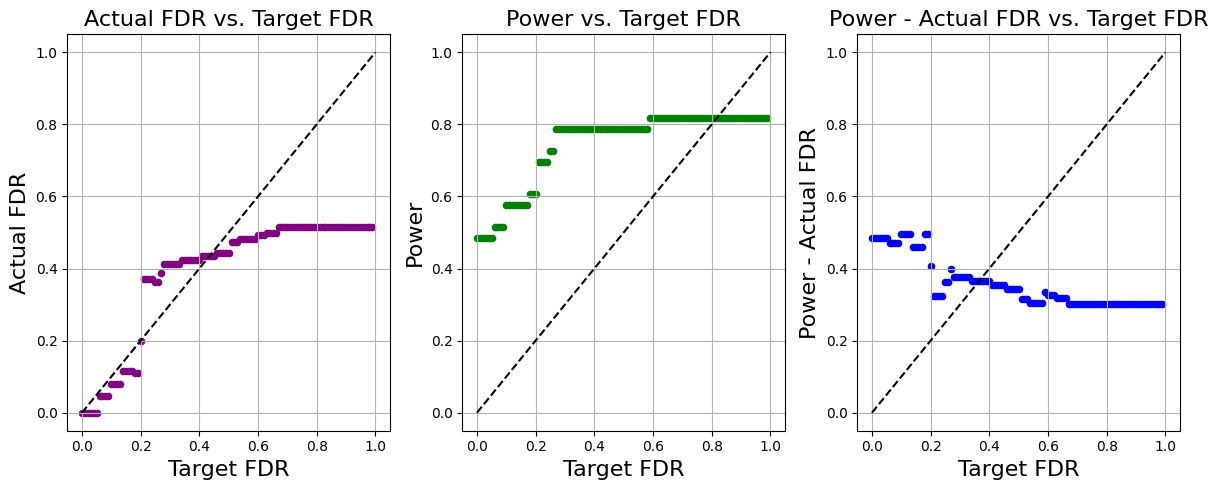

In [43]:
font_size = 16

T_FDR = []
power = []
Tar_FDR = []
my_array1 = np.arange(1, 34)
my_array2 = np.arange(34, 101)

for m in np.arange(0, 1, 0.01):
    T = []
    variable_select = []
    count = 0
    Tar_FDR.append(m)
    for i in W1:
        count1 = 0
        count2 = 0
        t = abs(i)
        for j in W1:
            if j < -t:
                count1 += 1
            if j >= t:
                count2 += 1
        q = count1 / max(count2, 1)
        if q <= m:
            T.append(t)
    for i in range(len(W1)):
        if W1[i] >= min(T):
            variable_select.append(i + 1)
    for n in variable_select:
        if n in my_array2:
            count += 1
    T_FDR.append(count / max(len(variable_select)+4,1))
    count1 = 0
    for n in variable_select:
        if n in my_array1:
            count1 += 1
    power.append(count1 / 33)

# Find the index with the maximum power value
max_power_index = np.argmax(power)

# Create a list to highlight the point with maximum power
highlight = [1 if i == max_power_index else 0 for i in range(len(Tar_FDR))]

plt.figure(figsize=(12, 5))

# Plotting True FDR vs. Target FDR
plt.subplot(1, 3, 1)
plt.scatter(Tar_FDR, T_FDR, c='purple', cmap='viridis', marker='o',s=20)
plt.xlabel('Target FDR',fontsize = 16)
plt.ylabel('Actual FDR',fontsize = 16)
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("Actual FDR vs. Target FDR",fontsize = 16)


# Plotting Power vs. Target FDR
plt.subplot(1, 3, 2)
plt.scatter(Tar_FDR, power, c='green', cmap='viridis', marker='o',s=20)
plt.xlabel('Target FDR',fontsize = 16)
plt.ylabel('Power',fontsize = 16)
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("Power vs. Target FDR",fontsize = 16)

p_f = []
for m in range(len(Tar_FDR)):
    p_f.append(power[m]-T_FDR[m])
    
plt.subplot(1, 3, 3)
plt.scatter(Tar_FDR, p_f, c='blue', cmap='viridis', marker='o',s =20)
plt.xlabel('Target FDR',fontsize = 16)
plt.ylabel('Power - Actual FDR',fontsize = 16)
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("Power - Actual FDR vs. Target FDR",fontsize = 16)

plt.tight_layout()
plt.show()

/tmp/ipykernel_47/3499068265.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Tar_FDR, T_FDR, c='purple', cmap='viridis', marker='o',s=20)
/tmp/ipykernel_47/3499068265.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Tar_FDR, power, c='green', cmap='viridis', marker='o',s=20)
/tmp/ipykernel_47/3499068265.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Tar_FDR, p_f, c='blue', cmap='viridis', marker='o',s =20)


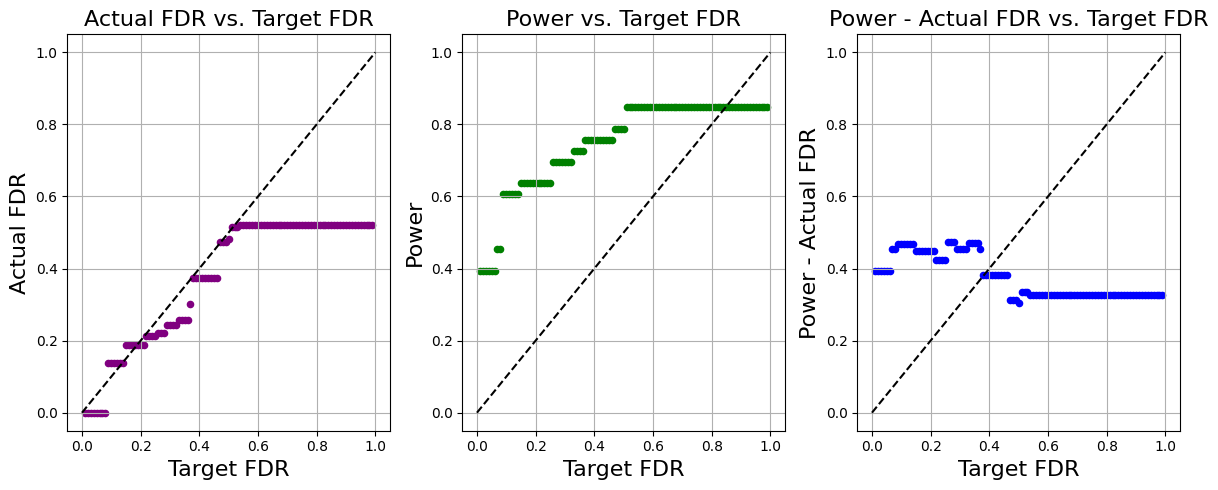

In [44]:
T_FDR = []
power = []
Tar_FDR = []
selected_vars2, threshold_value2 = select_variables2(W2,0.01)
for m in np.arange(0.01, 1, 0.01):
    T = []
    variable_select = []
    count = 0
    Tar_FDR.append(m)
    for i in W2:
        count1 = 0
        count2 = 0
        t = abs(i)
        for j in W2:
            if j < -t:
                count1 += 1
            if j >= t:
                count2 += 1
        q = count1 / max(count2, 1)
        if q <= m:
            T.append(t)
    for i in range(len(W2)):
        if W2[i] >= min(T):
            variable_select.append(i + 1)
#         print(min(T),variable_select)
    for n in variable_select:
        if n in my_array2:
            count += 1
    T_FDR.append(count / max(len(variable_select)+5,1))
    count1 = 0
    for n in variable_select:
        if n in my_array1:
            count1 += 1
    power.append(count1 / 33)

# Find the index with the maximum power value
max_power_index = np.argmax(power)

# Create a list to highlight the point with maximum power
highlight = [1 if i == max_power_index else 0 for i in range(len(Tar_FDR))]

plt.figure(figsize=(12, 5))

# Plotting True FDR vs. Target FDR
plt.subplot(1, 3, 1)
plt.scatter(Tar_FDR, T_FDR, c='purple', cmap='viridis', marker='o',s=20)
plt.xlabel('Target FDR',fontsize = 16)
plt.ylabel('Actual FDR',fontsize = 16)
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("Actual FDR vs. Target FDR",fontsize = 16)

# Plotting Power vs. Target FDR
plt.subplot(1, 3, 2)
plt.scatter(Tar_FDR, power, c='green', cmap='viridis', marker='o',s=20)
plt.xlabel('Target FDR',fontsize = 16)
plt.ylabel('Power',fontsize = 16)
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("Power vs. Target FDR",fontsize = 16)


p_f = []
for m in range(len(Tar_FDR)):
    p_f.append(power[m]-T_FDR[m])
plt.subplot(1, 3, 3)
plt.scatter(Tar_FDR, p_f, c='blue', cmap='viridis', marker='o',s =20)
plt.xlabel('Target FDR',fontsize = 16)
plt.ylabel('Power - Actual FDR',fontsize = 16)
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("Power - Actual FDR vs. Target FDR",fontsize = 16)

plt.tight_layout()
plt.show()

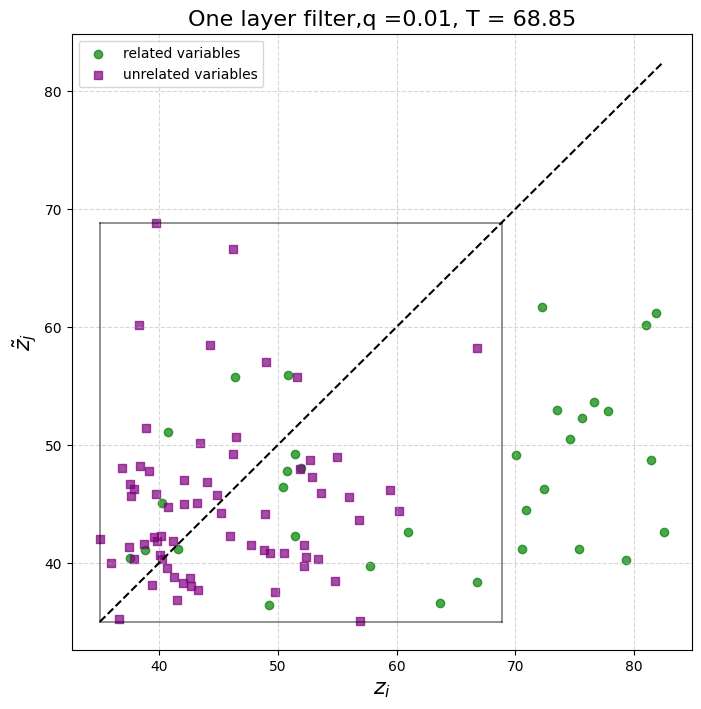

In [45]:
w_t = row_sums1[0:33]
w_tk = row_sums1[100:133]
w_Ft = row_sums1[33:100]
w_Ftk = row_sums1[133:]

plt.figure(figsize=(8, 8))

# Plotting the scatter points with different colors and markers
plt.scatter(w_t, w_tk, label='related variables', color='green', marker='o', alpha=0.7)
plt.scatter(w_Ft, w_Ftk, label='unrelated variables', color='purple', marker='s', alpha=0.7)

a1 = np.min(w_t)
b1 = np.min(w_tk)
c1 = np.min(w_Ft)
d1 = np.min(w_Ftk)

a2 = np.max(w_t)
b2 = np.max(w_tk)
c2 = np.max(w_Ft)
d2 = np.max(w_Ftk)

min_value = np.min(np.array([[a1, b1, c1, d1]]))
max_value = np.max(np.array([[a2, b2, c2, d2]]))

# Plotting the threshold line
plt.plot([min_value, max_value], [min_value,max_value], color='black', linestyle='--')
plt.plot([min_value, threshold_value1], [threshold_value1, threshold_value1], color='black', linewidth=1.2, linestyle='-', alpha=0.5)
plt.plot([threshold_value1, threshold_value1], [threshold_value1,min_value], color='black', linewidth=1.2, linestyle='-', alpha=0.5)
plt.plot([min_value, min_value], [min_value,np.max(threshold_value1)], color='black', linewidth=1.2, linestyle='-', alpha=0.5)
plt.plot([np.max(threshold_value1), min_value], [min_value,min_value], color='black', linewidth=1.2, linestyle='-', alpha=0.5)

# plt.xlim(38, 55)
# plt.ylim(38, 55)

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel('$z_i$',fontsize=16)
plt.ylabel('$\\tilde{z}_{j}$',fontsize=16)
plt.title(f'One layer filter,q =0.01, T = {"{:.2f}".format(threshold_value1)}',fontsize=16)

# plt.xlabel('$g_i$',fontsize=font_size)
# plt.ylabel('$\\tilde{g}_{i}$',fontsize=font_size)
# plt.title(f'Multiple layers filter, q =0.01,T = {"{:.2f}".format(threshold_value1)}',fontsize=15)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Displaying the plot
plt.show()


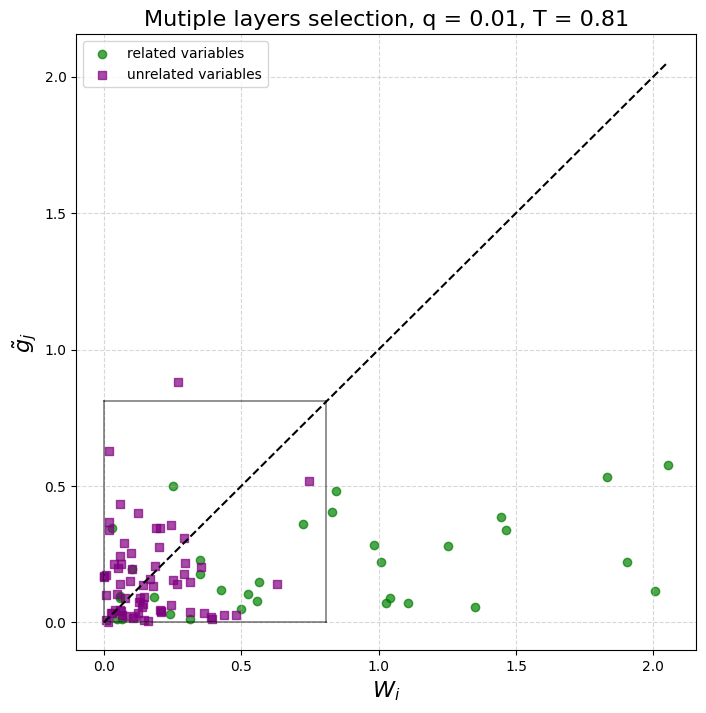

In [46]:
W2,Z = compute_W2(model_2, lambda_array)
selected_vars2, threshold_value2 = select_variables2(W2,0.01)
for i in range(len(Z)):
    Z[i] = abs(Z[i])/100

z_t = Z[0:33]
z_tk = Z[100:133]
z_Ft = Z[33:100]
z_Ftk = Z[133:]

plt.figure(figsize=(8, 8))

a1 = np.min(z_t)
b1 = np.min(z_tk)
c1 = np.min(z_Ft)
d1 = np.min(z_Ftk)

a2 = np.max(z_t)
b2 = np.max(z_tk)
c2 = np.max(z_Ft)
d2 = np.max(z_Ftk)

min_value = np.min([a1, b1, c1, d1])
max_value = np.max([a2, b2, c2, d2])
threshold_value2 = 0.81
# Plotting the scatter points with different colors and markers
plt.scatter(z_t, z_tk, label='related variables', color='green', marker='o', alpha=0.7)
plt.scatter(z_Ft, z_Ftk, label='unrelated variables', color='purple', marker='s', alpha=0.7)

# Plotting the threshold line
plt.plot([min_value, max_value], [min_value,max_value], color='black', linestyle='--')
plt.plot([np.min(min_value), np.max(threshold_value2)], [np.max(threshold_value2), np.max(threshold_value2)], color='black', linewidth=1.2, linestyle='-', alpha=0.5)

plt.plot([np.max(threshold_value2), np.max(threshold_value2)], [np.max(threshold_value2),min_value], color='black', linewidth=1.2, linestyle='-', alpha=0.5)
plt.plot([min_value, min_value], [min_value,np.max(threshold_value2)], color='black', linewidth=1.2, linestyle='-', alpha=0.5)
plt.plot([np.max(threshold_value2), min_value], [min_value,min_value], color='black', linewidth=1.2, linestyle='-', alpha=0.5)


# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel('$W_i$',fontsize=font_size)
plt.ylabel('$\\tilde{g}_{j}$',fontsize=font_size)
plt.title(f'Mutiple layers selection, q = 0.01, T = 0.81', fontsize=font_size)


# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Displaying the plot
plt.show()
